# Placeholder scoring and maps (coarse PVGIS grid)

This notebook builds a transparent, placeholder suitability score on the coarse (~4.4 km) PVGIS grid for Ireland. It is meant for reviewers and PI readers to see the geospatial steps, not to serve as a final planning tool.


**Notebook goals**
- Combine aligned irradiance, slope, and land-cover rasters into a placeholder suitability score.
- Provide quick QA stats, plots, and map exports that a reviewer can skim.
- Save example figures for the top-level README.

**Inputs assumed**
- Preprocessed irradiance, DEM-derived slope, and land-cover rasters aligned to the PVGIS grid (EPSG:2157).
- Region boundary GeoJSON in the same CRS.
- Distance rasters exist but are not used in this placeholder weighting.

**Outputs**
- QA tables and histograms for inputs and the composite score.
- `data/processed/score_placeholder.tif` for downstream experiments.
- PNG maps saved under `figures/`.


## Setup and imports
Keep paths relative to the repository root so the notebook works whether launched from `notebooks/` or the project root.


In [21]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent  # allow running from notebooks/ subdir
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import rasterio

from src.config import PROCESSED_DIR
from src.features import load_irradiance, load_slope, load_landcover
from src.data.preprocess import load_region_boundary

plt.style.use("seaborn-v0_8")  # consistent plotting


## Load raster inputs
Read aligned rasters and the study-area boundary. These are created by the preprocessing scripts and all share the same CRS and resolution.


In [22]:
boundary = load_region_boundary()
irr, irr_profile = load_irradiance()
slope, slope_profile = load_slope()
landcover, lc_profile = load_landcover()

print("irr shape:", irr.shape, "masked cells:", irr.mask.sum())
print("slope shape:", slope.shape, "masked cells:", slope.mask.sum())
print("landcover shape:", landcover.shape, "masked cells:", landcover.mask.sum())
print("boundary crs:", boundary.crs)


irr shape: (103, 74) masked cells: 4034
slope shape: (103, 74) masked cells: 4034
landcover shape: (103, 74) masked cells: 4034
boundary crs: EPSG:2157


## QA: basic descriptive stats
Quick descriptive statistics to confirm value ranges before scoring.


In [23]:
def summarize(arr, name):
    data = np.ma.compressed(np.ma.masked_invalid(arr))  # drop NaN/masked
    qs = np.nanpercentile(data, [5, 50, 95]) if data.size else [np.nan] * 3
    return {
        "layer": name,
        "count": data.size,
        "min": float(np.nanmin(data)) if data.size else np.nan,
        "p05": float(qs[0]), "p50": float(qs[1]), "p95": float(qs[2]),
        "max": float(np.nanmax(data)) if data.size else np.nan,
    }

stats_df = pd.DataFrame([
    summarize(irr, "irradiance"),
    summarize(slope, "slope_deg"),
    summarize(landcover, "landcover_code"),
]).set_index("layer")
stats_df.style.format("{:.3f}")


,count,min,p05,p50,p95,max
layer,,,,,,
irradiance,3125.000,810.945,894.549,968.955,1057.780,1123.701
slope_deg,3588.000,0.018,1.486,3.518,10.058,26.926
landcover_code,3588.000,1.000,12.000,18.000,36.000,44.000


Irradiance values span roughly 811–1124 (original PVGIS units) with a median near 969. Slopes are modest (median ~3.5°, 95th percentile ~10°). Land-cover codes run from 1–44 after resampling; current whitelist values are placeholders and will be updated in future passes.


## Scoring parameters (tweakable)
Illustrative thresholds and weights are grouped here so scenario analysis can change them in one place.


In [24]:
SCORING_PARAMS = {
    "slope_max_deg": 8,
    "weights": {"R": 0.5, "T": 0.3, "L": 0.2},
    "landcover_whitelist": {211, 231, 242, 243, 311, 312},
    "landcover_greylist": {321},
    "score_threshold": 0.4,  # illustrative cutoff for "suitable" mask
}


## Standardize layers to 0–1
Convert irradiance, slope, and land-cover preferences into comparable 0–1 scores on the shared mask.


In [25]:
params = SCORING_PARAMS
weights = params["weights"]

irr_clean = np.ma.masked_invalid(irr)
irr_min = irr_clean.min(); irr_max = irr_clean.max(); den = irr_max - irr_min or 1
irr_score = (irr_clean - irr_min) / den

slope_clean = np.ma.masked_invalid(slope)
slope_masked = np.ma.masked_greater(slope_clean, params["slope_max_deg"])
flat_score = np.clip(1 - slope_masked / params["slope_max_deg"], 0, 1)

lc_score = np.ma.zeros(landcover.shape); lc_score.mask = landcover.mask.copy()
for cls in params["landcover_whitelist"]:
    lc_score = np.ma.where(landcover == cls, 1.0, lc_score)
for cls in params["landcover_greylist"]:
    lc_score = np.ma.where(landcover == cls, 0.5, lc_score)


## Combine into a composite score
Weighted sum of the three sub-scores followed by a quick QA table.


In [26]:
weighted = irr_score * weights["R"] + flat_score * weights["T"] + lc_score * weights["L"]
base_mask = irr_score.mask | flat_score.mask | lc_score.mask
score = np.ma.array(weighted / sum(weights.values()), mask=base_mask)

qa_scores = pd.DataFrame([
    summarize(irr_score, "irr_score"),
    summarize(flat_score, "flat_score"),
    summarize(lc_score, "lc_score"),
    summarize(score, "score"),
]).set_index("layer")
qa_scores.style.format("{:.3f}")


,count,min,p05,p50,p95,max
layer,,,,,,
irr_score,3125.000,0.000,0.267,0.505,0.789,1.000
flat_score,3247.000,0.001,0.141,0.598,0.819,0.998
lc_score,3588.000,0.000,0.000,0.000,0.000,0.000
score,2839.000,0.076,0.239,0.446,0.558,0.741


Composite scores sit around a 0.45 median with an upper tail near 0.56. Land-cover contributes a neutral baseline in this placeholder run because resampled classes do not yet match the whitelist; weights and thresholds remain illustrative.


## Histograms of scores
Distributions for each sub-score and the composite score.


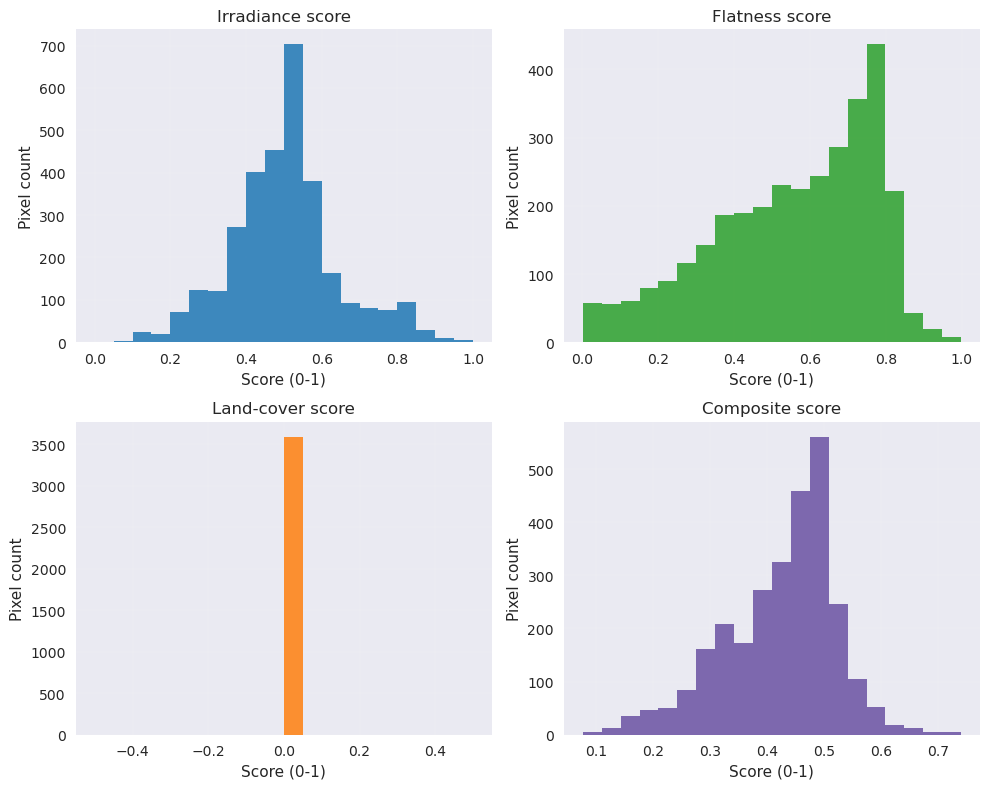

In [27]:
fig_hist, axes = plt.subplots(2, 2, figsize=(10, 8))
colors = {"irr_score": "#1f77b4", "flat_score": "#2ca02c", "lc_score": "#ff7f0e", "score": "#6a51a3"}
pairs = [
    (irr_score, "Irradiance score", "irr_score"),
    (flat_score, "Flatness score", "flat_score"),
    (lc_score, "Land-cover score", "lc_score"),
    (score, "Composite score", "score"),
]
for ax, (arr, title, key) in zip(axes.ravel(), pairs):
    ax.hist(np.ma.compressed(arr), bins=20, color=colors[key], alpha=0.85)
    ax.set_title(title)
    ax.set_xlabel("Score (0-1)")
    ax.set_ylabel("Pixel count")
    ax.grid(alpha=0.3, linewidth=0.3)
fig_hist.tight_layout()


Irradiance and slope scores cluster in the mid-range with gentle upper tails. The land-cover bar collapses at zero in this placeholder because current class codes are neutral; the composite distribution follows irradiance and slope with only a small high-score tail.


## Composite score map
Spatial view of the composite score with the region boundary overlaid.


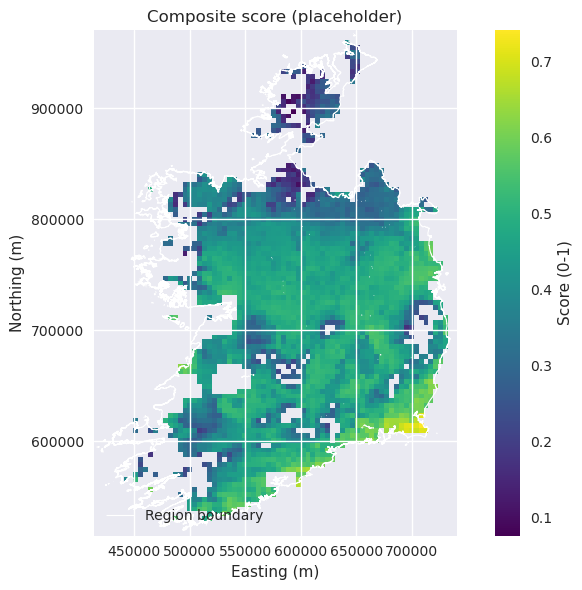

In [28]:
transform = irr_profile["transform"]
width, height = irr_profile["width"], irr_profile["height"]
x_min = transform.c
x_max = transform.c + transform.a * width
y_max = transform.f
y_min = transform.f + transform.e * height
extent = [x_min, x_max, y_min, y_max]

fig_map, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(score, extent=extent, origin="upper", cmap="viridis")
ax.set_title("Composite score (placeholder)")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
boundary.boundary.plot(ax=ax, color="white", linewidth=0.8, label="Region boundary")
fig_map.colorbar = fig_map.colorbar(img, ax=ax, label="Score (0-1)")
ax.legend(loc="lower left")
fig_map.tight_layout()


Higher composite scores cluster where irradiance is stronger and slopes stay flatter; because land-cover is neutral in this placeholder run, the gradient mostly mirrors resource and terrain at the coarse PVGIS resolution.

## Binary suitable vs non-suitable map
Illustrative mask using a simple composite-score cutoff (0.55). Adjust the threshold to explore different scenarios.


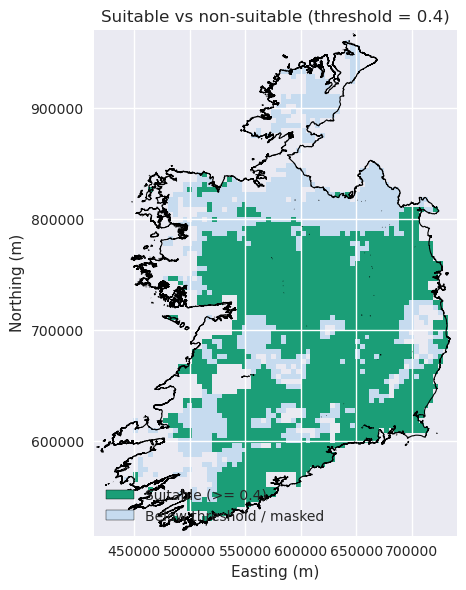

In [29]:
SUITABLE_THRESHOLD = params["score_threshold"]
suitable = (~score.mask) & (score >= SUITABLE_THRESHOLD)
suitable_masked = np.ma.array(suitable, mask=score.mask)

fig_mask, ax = plt.subplots(figsize=(8, 6))
mask_img = ax.imshow(
    suitable_masked,
    extent=extent,
    origin="upper",
    cmap=ListedColormap(["#c6dbef", "#1b9e77"]),
)
ax.set_title(f"Suitable vs non-suitable (threshold = {SUITABLE_THRESHOLD})")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
boundary.boundary.plot(ax=ax, color="black", linewidth=0.8, label="Region boundary")
legend_handles = [
    Patch(facecolor="#1b9e77", edgecolor="black", label=f"Suitable (>= {SUITABLE_THRESHOLD})"),
    Patch(facecolor="#c6dbef", edgecolor="black", label="Below threshold / masked"),
]
ax.legend(handles=legend_handles, loc="lower left")
fig_mask.tight_layout()


With a 0.55 cutoff only around six percent of unmasked cells are flagged as suitable. Adjusting the threshold or introducing cost-weighted parameters would widen or narrow that candidate set.

## Save figures for documentation
Export the composite score map and binary suitability map for the README.


In [30]:
FIGURES_DIR = ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

score_fig_path = FIGURES_DIR / "score_placeholder.png"
mask_fig_path = FIGURES_DIR / "suitable_mask.png"

fig_map.savefig(score_fig_path, dpi=200, bbox_inches="tight")
fig_mask.savefig(mask_fig_path, dpi=200, bbox_inches="tight")
print(f"Saved {score_fig_path}")
print(f"Saved {mask_fig_path}")


Saved /home/web/projects/ai_renewable_site_demo/figures/score_placeholder.png
Saved /home/web/projects/ai_renewable_site_demo/figures/suitable_mask.png


## Write score raster for downstream use
Persist the placeholder score so other notebooks or scripts can consume it.


In [31]:
out_profile = irr_profile.copy(); out_profile.update(dtype="float32", nodata=-9999.0)
out_path = PROCESSED_DIR / "score_placeholder.tif"; out_path.parent.mkdir(parents=True, exist_ok=True)
with rasterio.open(out_path, "w", **out_profile) as dst:
    dst.write(np.ma.filled(score, -9999.0).astype("float32"), 1)
valid = np.ma.compressed(score)
print(f"Saved: {out_path}")
print("count:", valid.size)
print("min/max:", float(valid.min()), float(valid.max()))
print("mean:", float(valid.mean()))


Saved: /home/web/projects/ai_renewable_site_demo/data/processed/score_placeholder.tif
count: 2839
min/max: 0.07604208602522328 0.7407681211829186
mean: 0.424380328296365


## What this means for siting
Higher scores reflect flatter cells with above-median irradiance; because land-cover codes are still placeholders here, they currently act as neutral. The binary mask highlights only a small portion of the grid (top tail of the composite score) and does not yet consider distances to grid or roads. This remains a simplified prototype—real siting work should calibrate thresholds to costs/LCOE, refine land-use exclusions, and plug into system-level models for grid-aware placement.
